TokaMaker Example: Simple voltage coil evolution in HBT-EP {#doc_tMaker_HBT_ex3}
==========
In this example we show how to use voltage-specified coils

This example utilizes the mesh built in \ref doc_tMaker_HBT_ex1.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) python package, which is installable using `pip` or other standard methods.

In [1]:
import os
import sys
import copy
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain()" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a [python wrapper](https://pypi.org/project/triangle/).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_power_flux_fun

## Setup model

### Initialize OFT environment
We now create a \ref OpenFUSIONToolkit.OFT_env "OFT_env" instance for execution using two threads. This environment will be shared by both our TokaMaker models below.

In [3]:
myOFT = OFT_env(nthreads=2)

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   tMaker_vcoils
Revision id:          33de709
Parallelization Info:
  # of MPI tasks      =    1
  # of NUMA nodes     =    1
  # of OpenMP threads =    2
Fortran input file    = /var/folders/52/n5qxh27n4w19qxzqygz2btbw0000gn/T/oft_56905/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Build two TokaMaker models
To illustrate the use of Vcoils we build two models of HBT-EP: 1) The full model of HBT-EP with passive conducting regions (VV, Shell) and 2) A reduced model with high resistivity in the VV and Shell, which can be reproduced with a simple L-R ODE.

We use the same mesh for both models, generated in \ref doc_tMaker_HBT_ex1 and loaded using \ref OpenFUSIONToolkit.TokaMaker.load_gs_mesh "load_gs_mesh()". Before calling \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_regions "setup_regions()" on the simplified model we set the resistivity to large values in the VV and Shell.

In [4]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('HBT_mesh.h5')
#
mygs_full = TokaMaker(myOFT)
mygs_full.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs_full.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs_full.setup(order=3, F0=0.2518*1.23) # F0 = B0 * R0
#
mygs_nocond = TokaMaker(myOFT)
cond_dict_nocond = copy.deepcopy(cond_dict)
cond_dict_nocond['VV']['eta'] = 1.E4
cond_dict_nocond['SHELL']['eta'] = 1.E4
mygs_nocond.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs_nocond.setup_regions(cond_dict=cond_dict_nocond,coil_dict=coil_dict)
mygs_nocond.setup(order=3, F0=0.2518*1.23) # F0 = B0 * R0


**** Loading OFT surface mesh

**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  3.278E+00
    # of points  =    3736
    # of edges   =   11087
    # of cells   =    7352
    # of boundary points =     118
    # of boundary edges  =     118
    # of boundary cells  =     118
  Resolution statistics:
    hmin =  1.959E-04
    hrms =  3.418E-02
    hmax =  9.532E-02
  Surface grounded at vertex     804


**** Creating Lagrange FE space
  Order  =    3
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    3.7740000000000000E-003

**** Loading OFT surface mesh

**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  3.278E+00
    # of points  =    3736
    # of edges   =   11087
    # of cells   =    7352
    # of boundary points =     118
    # of boundary edges  =     118
    # of boundary cells  =     118
  Resolution statistics:
    hmin 

## Run simplified model

In [5]:
mygs = mygs_nocond
mygs.settings.pm=False
mygs.update_settings()
#
mygs.set_coil_currents({'OH': 1.E3})
psi_vac = mygs.vac_solve()
#
rcoils = {'OH': 10.E-3, 'VF': 10.E-3}
mygs.set_vcoils(rcoils)
coils_volt = {'OH': 0.0} #5.0}
#
dt=1.E-3
new_coil_currents, _ = mygs.get_coil_currents()
psi_new = psi_vac.copy()
coil_hist = [mygs.coil_dict2vec(new_coil_currents),]
for i in range(160):
    mygs.set_psi_dt(psi_new,dt,new_coil_currents,coils_volt)
    psi_new = mygs.vac_solve()
    new_coil_currents, _ = mygs.get_coil_currents()
    coil_hist.append(mygs.coil_dict2vec(new_coil_currents))
coil_hist = np.array(coil_hist)
mygs.settings.pm=True
mygs.update_settings()

### Repeat using NL solver
Verify NL solver works correctly, but system itself is still linear

In [6]:
mygs.settings.pm=False
mygs.update_settings()
mygs.set_coil_currents({'OH': 1.E3})
mygs.set_psi(psi_vac)
#
coil_hist_nl = [mygs.coil_dict2vec(mygs.get_coil_currents()[0])]
mygs.setup_td(dt,1.E-13,1.E-11,pre_plasma=False)
sim_time = 0.0
for i in range(160):
    sim_time, _, nl_its, lin_its, nretry = mygs.step_td(sim_time,dt)
    coil_hist_nl.append(mygs.coil_dict2vec(mygs.get_coil_currents()[0]))
coil_hist_nl = np.array(coil_hist_nl)
mygs.settings.pm=True
mygs.update_settings()

### Compute L-R ODE comparison
This system should behave as a simple 2x2 ODE for the OH and VF coils.

In [7]:
Lmat = mygs.get_coil_Lmat()[:-1,:-1] # Get only coil part of L matrix (skip plasma since there isn't one)
Lmat[:,-1]=0.0; Lmat[-1,:]=0.0; Lmat[-1,-1] = 1.0 # Do not evolve shaping coil
Rmat=np.diag(mygs.coil_dict2vec(rcoils)) # Create resistance matrix
#
new_coil_simple = coil_hist[0]
analytic_op = np.linalg.inv(Lmat+dt*Rmat)
coil_hist_simple = [new_coil_simple,]
for i in range(160):
    volt_vec=mygs.coil_dict2vec(coils_volt)
    new_coil_simple = np.dot(analytic_op,dt*volt_vec+np.dot(Lmat,new_coil_simple))
    coil_hist_simple.append(new_coil_simple)
coil_hist_simple = np.array(coil_hist_simple)

 Starting LU solver: umfpack F


### Compare TokaMaker and ODE results

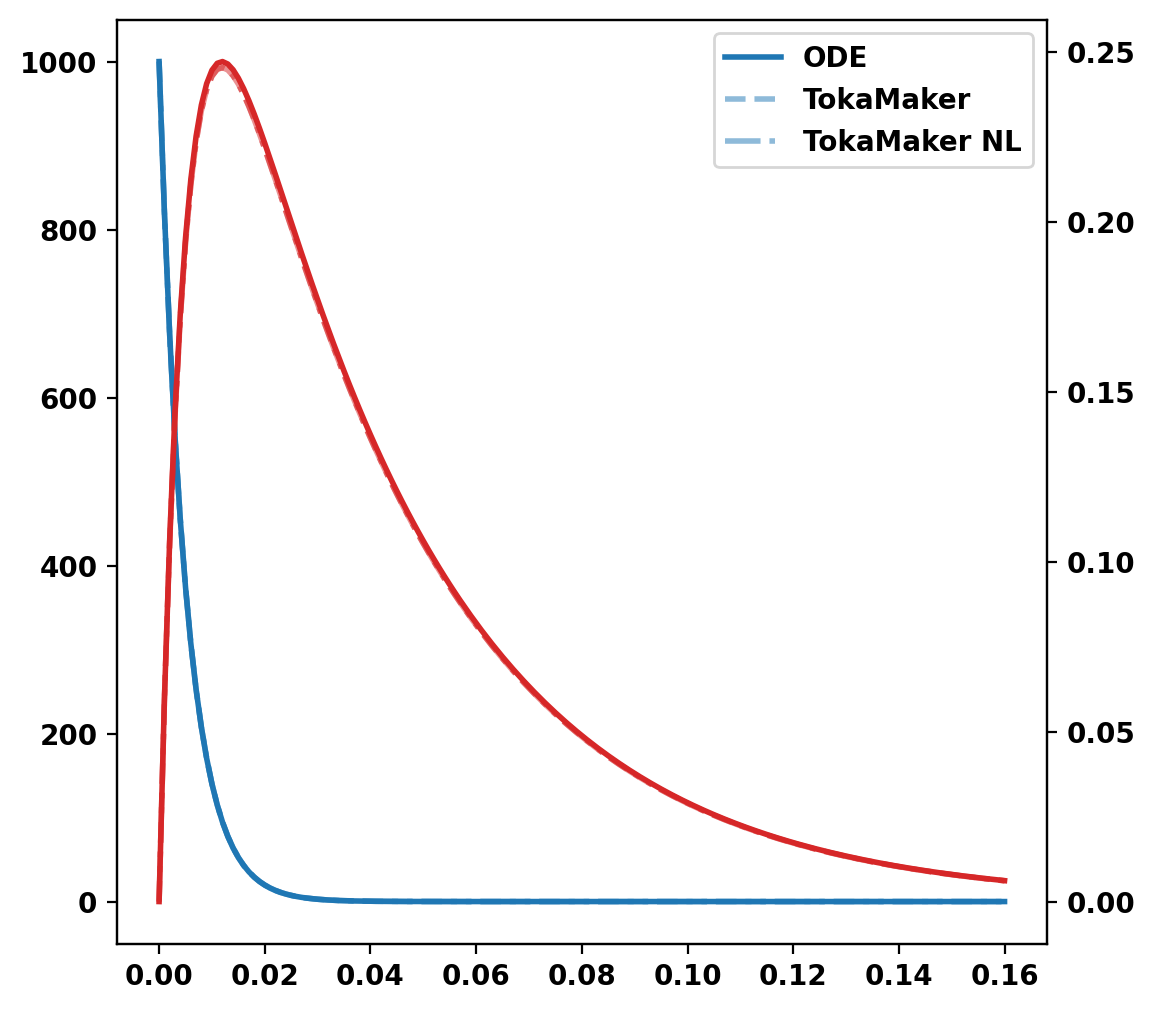

In [8]:
fig, ax = plt.subplots(1,1)
time = np.cumsum(dt*np.ones((len(coil_hist_simple),)))-dt
ax.plot(time,coil_hist_simple[:,0],color='tab:blue',label='ODE')
ax.plot(time,coil_hist[:,0],'--',color='tab:blue',alpha=0.5,label='TokaMaker')
ax.plot(time,coil_hist_nl[:,0],'-.',color='tab:blue',alpha=0.5,label='TokaMaker NL')
ax2=ax.twinx()
ax2.plot(time,coil_hist_simple[:,1],color='tab:red')
ax2.plot(time,coil_hist[:,1],'--',color='tab:red',alpha=0.5)
ax2.plot(time,coil_hist_nl[:,1],'-.',color='tab:red',alpha=0.5)
_ = ax.legend()

## Repeat with one Icoil and one Vcoil

In [9]:
mygs.settings.pm=False
mygs.update_settings()
mygs.set_psi_dt(psi_new,2.0*dt,new_coil_currents,coils_volt)
psi_vac = mygs.vac_solve()
mygs.set_psi_dt(psi_new,-dt,new_coil_currents,coils_volt)
mygs.set_coil_currents({'OH': 1.E3})
psi_vac = mygs.vac_solve()
#
rcoils = {'VF': 10.E-3}
mygs.set_vcoils(rcoils)
coils_volt = {}
#
dt=1.E-3
old_coil_currents, _ = mygs.get_coil_currents()
psi_new = psi_vac.copy()
coil_hist = [mygs.coil_dict2vec(old_coil_currents),]
for i in range(159):
    mygs.set_psi_dt(psi_new,dt,old_coil_currents,coils_volt)
    new_coil_currents = copy.deepcopy(old_coil_currents); new_coil_currents['OH'] = coil_hist_simple[i+1,0]
    mygs.set_coil_currents(new_coil_currents)
    psi_new = mygs.vac_solve()
    old_coil_currents, _ = mygs.get_coil_currents()
    coil_hist.append(mygs.coil_dict2vec(old_coil_currents))
coil_hist = np.array(coil_hist)
mygs.settings.pm=True
mygs.update_settings()

### Repeat using NL solver
Verify NL solver works correctly, but system itself is still linear

In [10]:
mygs.set_coil_currents({'OH': 1.E3})
mygs.set_psi(psi_vac)
#
old_coil_currents, _ = mygs.get_coil_currents()
coil_hist_nl = [mygs.coil_dict2vec(old_coil_currents)]
mygs.settings.pm=False
mygs.update_settings()
mygs.setup_td(dt,1.E-13,1.E-11,pre_plasma=False)
sim_time = 0.0
for i in range(159):
    new_coil_currents = copy.deepcopy(old_coil_currents); new_coil_currents['OH'] = coil_hist_simple[i+1,0]
    sim_time, _, nl_its, lin_its, nretry = mygs.step_td(sim_time,dt,coil_currents=new_coil_currents)
    old_coil_currents, _ = mygs.get_coil_currents()
    coil_hist_nl.append(mygs.coil_dict2vec(old_coil_currents))
coil_hist_nl = np.array(coil_hist_nl)
mygs.settings.pm=True
mygs.update_settings()

### Compare to ODE results

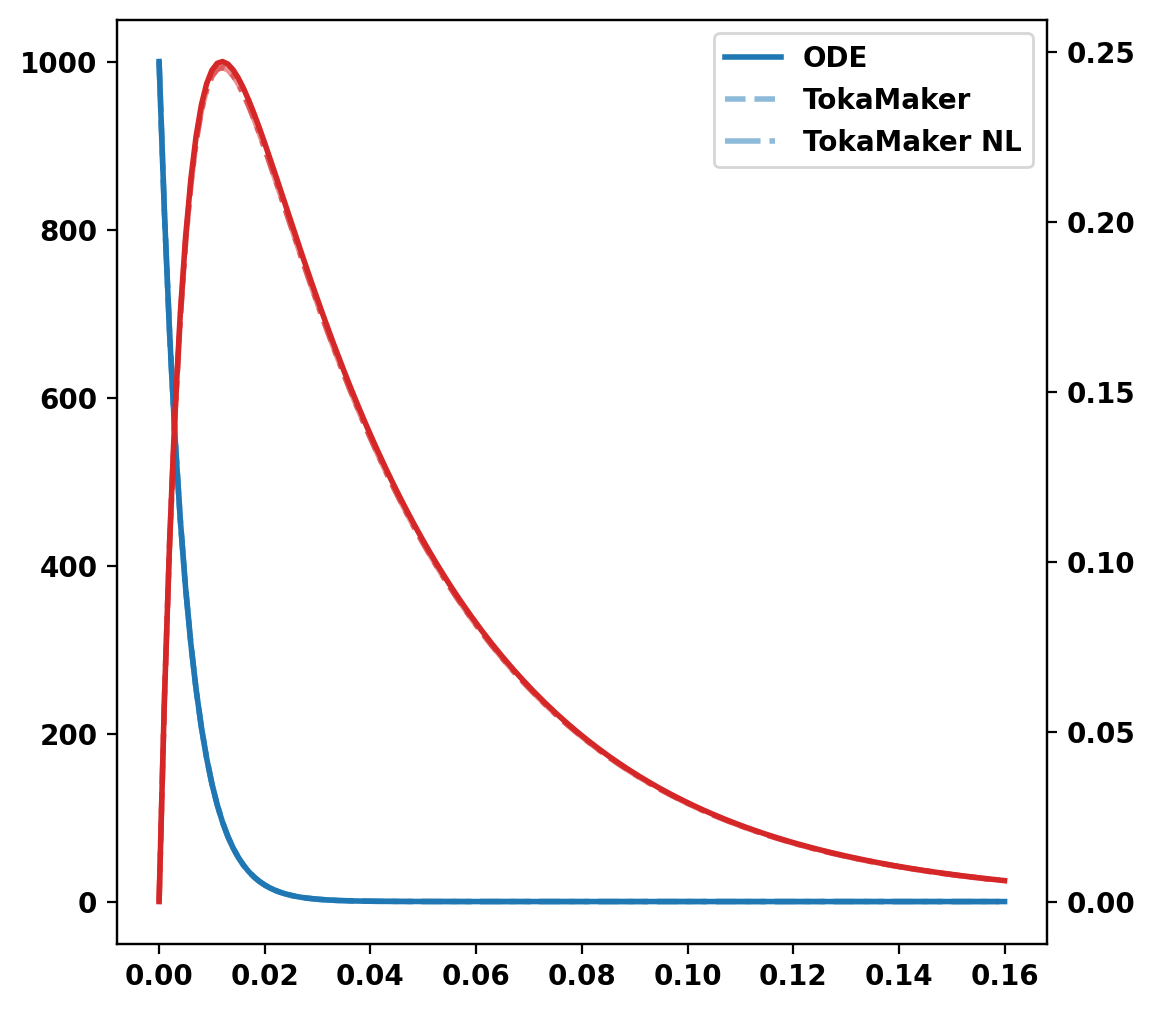

In [11]:
fig, ax = plt.subplots(1,1)
time = np.cumsum(dt*np.ones((len(coil_hist_simple),)))-dt
ax.plot(time,coil_hist_simple[:,0],color='tab:blue',label='ODE')
ax.plot(time[:-1],coil_hist[:,0],'--',color='tab:blue',alpha=0.5,label='TokaMaker')
ax.plot(time[:-1],coil_hist_nl[:,0],'-.',color='tab:blue',alpha=0.5,label='TokaMaker NL')
ax2=ax.twinx()
ax2.plot(time,coil_hist_simple[:,1],color='tab:red')
ax2.plot(time[:-1],coil_hist[:,1],'--',color='tab:red',alpha=0.5)
ax2.plot(time[:-1],coil_hist_nl[:,1],'-.',color='tab:red',alpha=0.5)
_ = ax.legend()

## Run full model

In [12]:
mygs = mygs_full
#
mygs.settings.pm=False
mygs.update_settings()
#
mygs.set_coil_currents({'OH': 1.E3})
psi_vac = mygs.vac_solve()
#
rcoils = {'OH': 10.E-3, 'VF': 10.E-3}
mygs.set_vcoils(rcoils)
coils_volt = {'OH': 0.0}
#
dt=1.E-3
new_coil_currents, _ = mygs.get_coil_currents()
psi_new = psi_vac.copy()
coil_hist = [mygs.coil_dict2vec(new_coil_currents),]
for i in range(160):
    mygs.set_psi_dt(psi_new,dt,new_coil_currents,coils_volt)
    psi_new = mygs.vac_solve()
    new_coil_currents, _ = mygs.get_coil_currents()
    coil_hist.append(mygs.coil_dict2vec(new_coil_currents))
coil_hist = np.array(coil_hist)
mygs.settings.pm=True
mygs.update_settings()

### Repeat using NL solver
Verify NL solver works correctly, but system itself is still linear

In [13]:
mygs.settings.pm=False
mygs.update_settings()
mygs.set_coil_currents({'OH': 1.E3})
mygs.set_psi(psi_vac)
#
coil_hist_nl = [mygs.coil_dict2vec(mygs.get_coil_currents()[0])]
mygs.setup_td(dt,1.E-13,1.E-11,pre_plasma=False)
sim_time = 0.0
for i in range(160):
    sim_time, _, nl_its, lin_its, nretry = mygs.step_td(sim_time,dt)
    coil_hist_nl.append(mygs.coil_dict2vec(mygs.get_coil_currents()[0]))
coil_hist_nl = np.array(coil_hist_nl)
mygs.settings.pm=True
mygs.update_settings()

### Compute L-R ODE comparison

In [14]:
new_coil_simple = coil_hist[0]
coil_hist_simple = [new_coil_simple,]
for i in range(160):
    volt_vec=mygs.coil_dict2vec(coils_volt)
    new_coil_simple = np.dot(analytic_op,dt*volt_vec+np.dot(Lmat,new_coil_simple))
    coil_hist_simple.append(new_coil_simple)
coil_hist_simple = np.array(coil_hist_simple)

### Compare TokaMaker and ODE results
In this case the TokaMaker and ODE results should _only_ agree late in time, since the ODE does not include the VV or Shell.

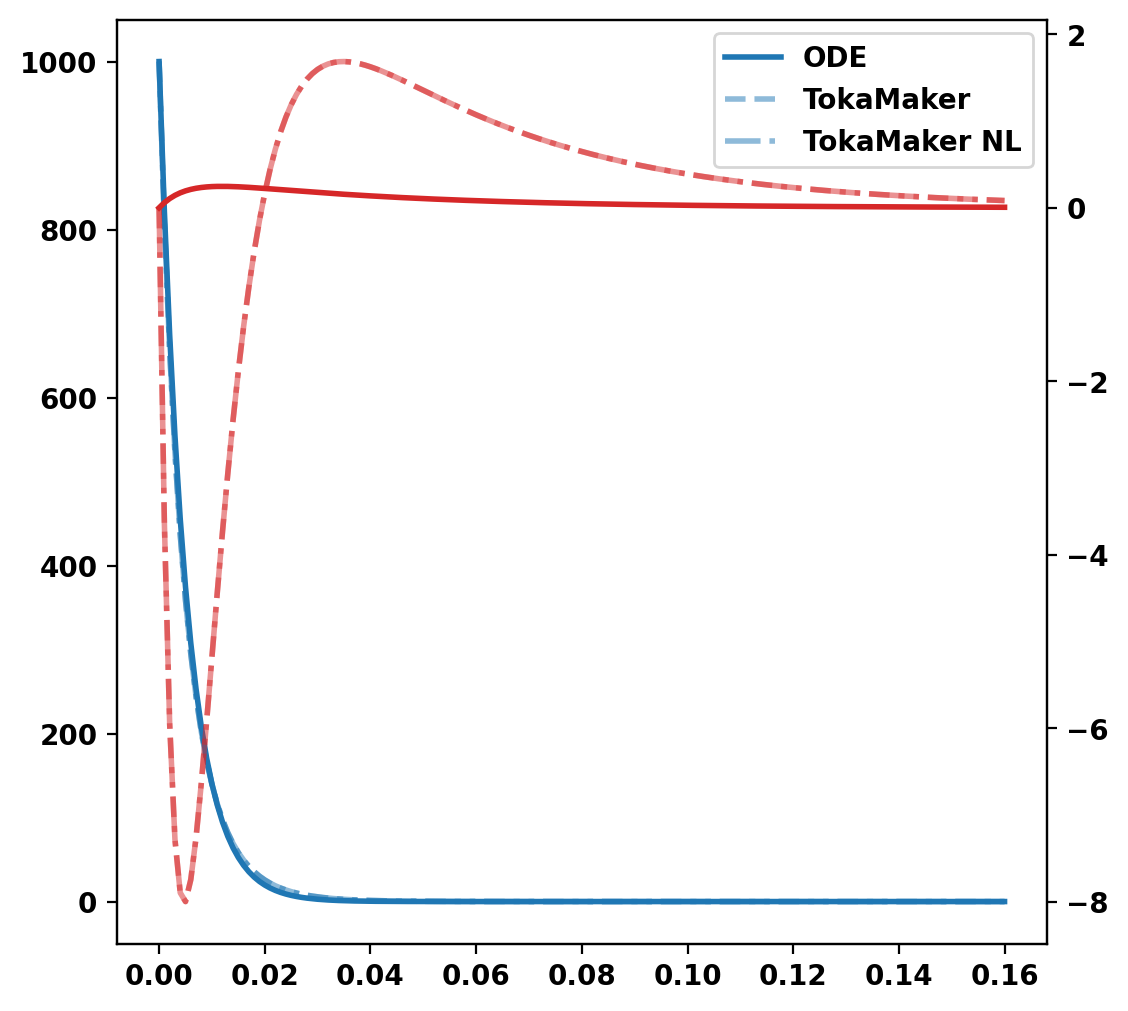

In [15]:
fig, ax = plt.subplots(1,1)
time = np.cumsum(dt*np.ones((len(coil_hist),)))-dt
ax.plot(time,coil_hist_simple[:,0],color='tab:blue',label='ODE')
ax.plot(time,coil_hist[:,0],'--',color='tab:blue',alpha=0.5,label='TokaMaker')
ax.plot(time,coil_hist_nl[:,0],'-.',color='tab:blue',alpha=0.5,label='TokaMaker NL')
ax2=ax.twinx()
ax2.plot(time,coil_hist_simple[:,1],color='tab:red')
ax2.plot(time,coil_hist[:,1],'--',color='tab:red',alpha=0.5)
ax2.plot(time,coil_hist_nl[:,1],'-.',color='tab:red',alpha=0.5)
_ = ax.legend()

### Plot eddy currents

Starting CG solver
     0  0.000000E+00  0.000000E+00  1.691097E-07
     1 -7.873203E-10  1.353692E-02  8.254653E-08  6.097883E-06
     2 -8.360726E-10  1.333031E-02  4.042682E-08  3.032699E-06
     3 -8.513913E-10  1.337349E-02  1.995725E-08  1.492299E-06
     4 -8.548581E-10  1.363831E-02  1.012042E-08  7.420587E-07
     5 -8.554565E-10  1.379286E-02  4.460942E-09  3.234240E-07
     6 -8.555727E-10  1.380921E-02  2.220260E-09  1.607811E-07
     7 -8.555953E-10  1.380685E-02  1.144602E-09  8.290101E-08
     8 -8.556020E-10  1.380955E-02  4.359230E-10  3.156678E-08
     9 -8.556029E-10  1.381139E-02  1.686939E-10  1.221411E-08
    10 -8.556030E-10  1.381141E-02  9.536271E-11  6.904631E-09
    20 -8.556031E-10  1.381056E-02  2.811696E-14  2.035903E-12


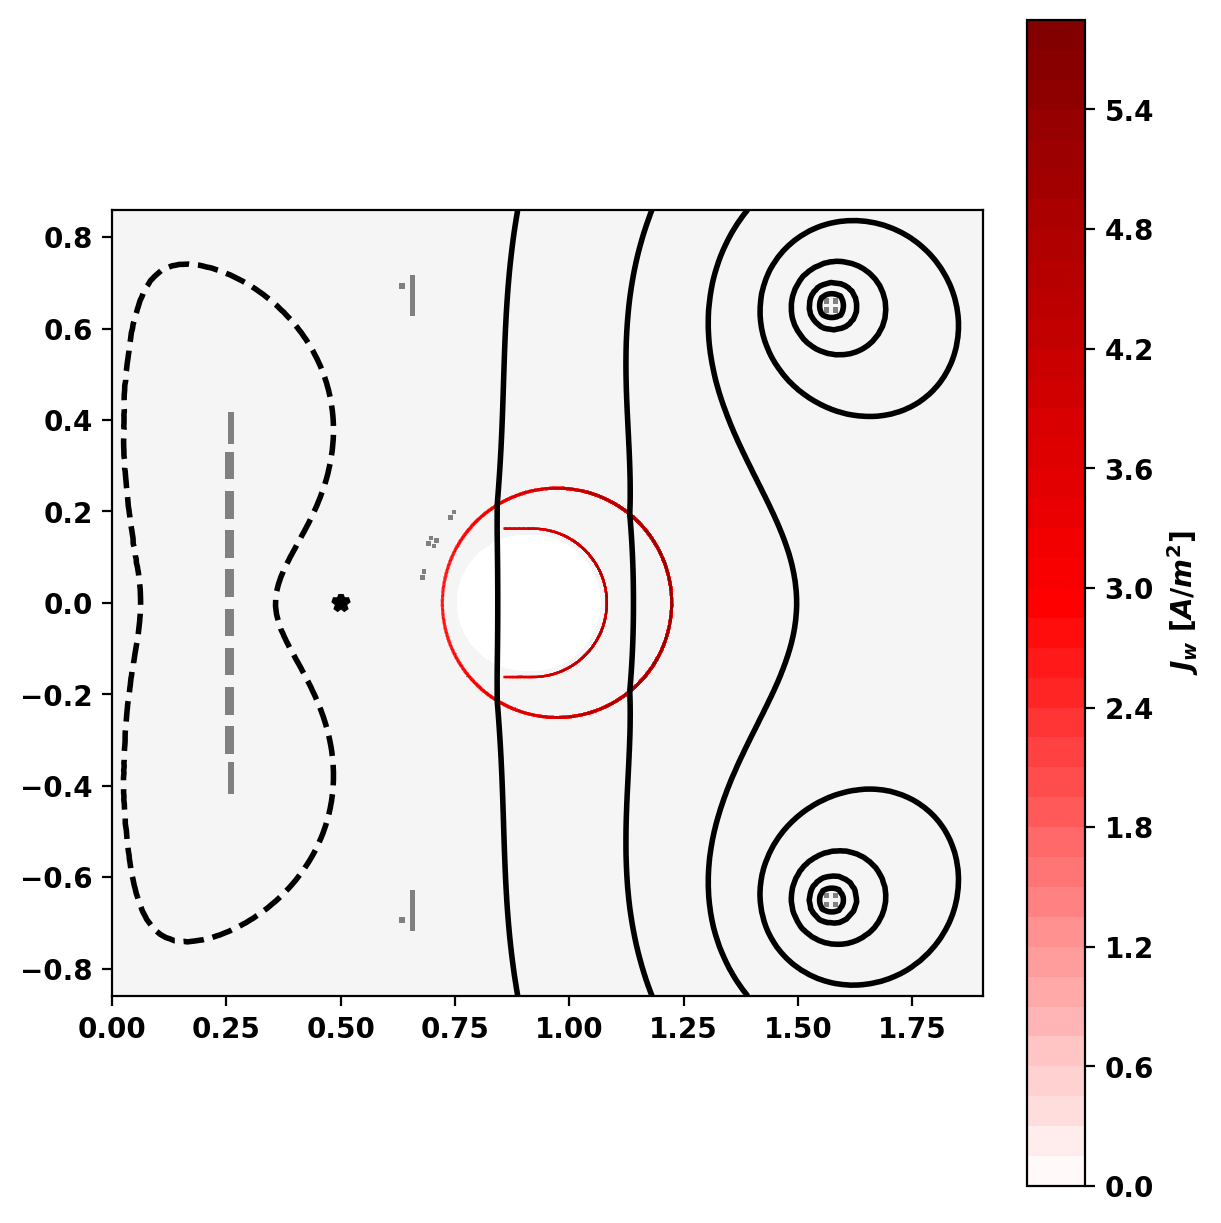

In [16]:
fig, ax = plt.subplots(1,1,constrained_layout=True)
# Plot flux evolution in time
mygs.plot_machine(fig,ax,coil_colormap=None,limiter_color=None)
mygs.plot_psi(fig,ax,psi=psi_new,normalized=False,plasma_nlevels=10,plasma_color='k',vacuum_levels=None,xpoint_color=None)
_ = mygs.plot_eddy(fig,ax,psi=psi_new,colormap='seismic',symmap=True)

## Repeat with one Icoil and one Vcoil

In [17]:
mygs.settings.pm=False
mygs.update_settings()
#
mygs.set_psi_dt(psi_new,2.0*dt,new_coil_currents,coils_volt)
psi_vac = mygs.vac_solve()
mygs.set_psi_dt(psi_new,-dt,new_coil_currents,coils_volt)
mygs.set_coil_currents({'OH': 1.E3})
psi_vac = mygs.vac_solve()
#
rcoils = {'VF': 10.E-3}
mygs.set_vcoils(rcoils)
coils_volt = {}
#
dt=1.E-3
old_coil_currents, _ = mygs.get_coil_currents()
psi_new = psi_vac.copy()
coil_hist_new = [mygs.coil_dict2vec(old_coil_currents),]
for i in range(159):
    mygs.set_psi_dt(psi_new,dt,old_coil_currents,coils_volt)
    new_coil_currents = copy.deepcopy(old_coil_currents); new_coil_currents['OH'] = coil_hist[i+1,0]
    mygs.set_coil_currents(new_coil_currents)
    psi_new = mygs.vac_solve()
    old_coil_currents, _ = mygs.get_coil_currents()
    coil_hist_new.append(mygs.coil_dict2vec(old_coil_currents))
coil_hist_new = np.array(coil_hist_new)
mygs.settings.pm=True
mygs.update_settings()

### Repeat using NL solver
Verify NL solver works correctly, but system itself is still linear

In [18]:
mygs.set_coil_currents({'OH': 1.E3})
mygs.set_psi(psi_vac)
#
old_coil_currents, _ = mygs.get_coil_currents()
coil_hist_nl = [mygs.coil_dict2vec(old_coil_currents)]
mygs.settings.pm=False
mygs.update_settings()
mygs.setup_td(dt,1.E-13,1.E-11,pre_plasma=False)
sim_time = 0.0
for i in range(159):
    new_coil_currents = copy.deepcopy(old_coil_currents); new_coil_currents['OH'] = coil_hist[i+1,0]
    sim_time, _, nl_its, lin_its, nretry = mygs.step_td(sim_time,dt,coil_currents=new_coil_currents)
    old_coil_currents, _ = mygs.get_coil_currents()
    coil_hist_nl.append(mygs.coil_dict2vec(old_coil_currents))
coil_hist_nl = np.array(coil_hist_nl)
mygs.settings.pm=True
mygs.update_settings()

### Compare Vcoil and Icoil results

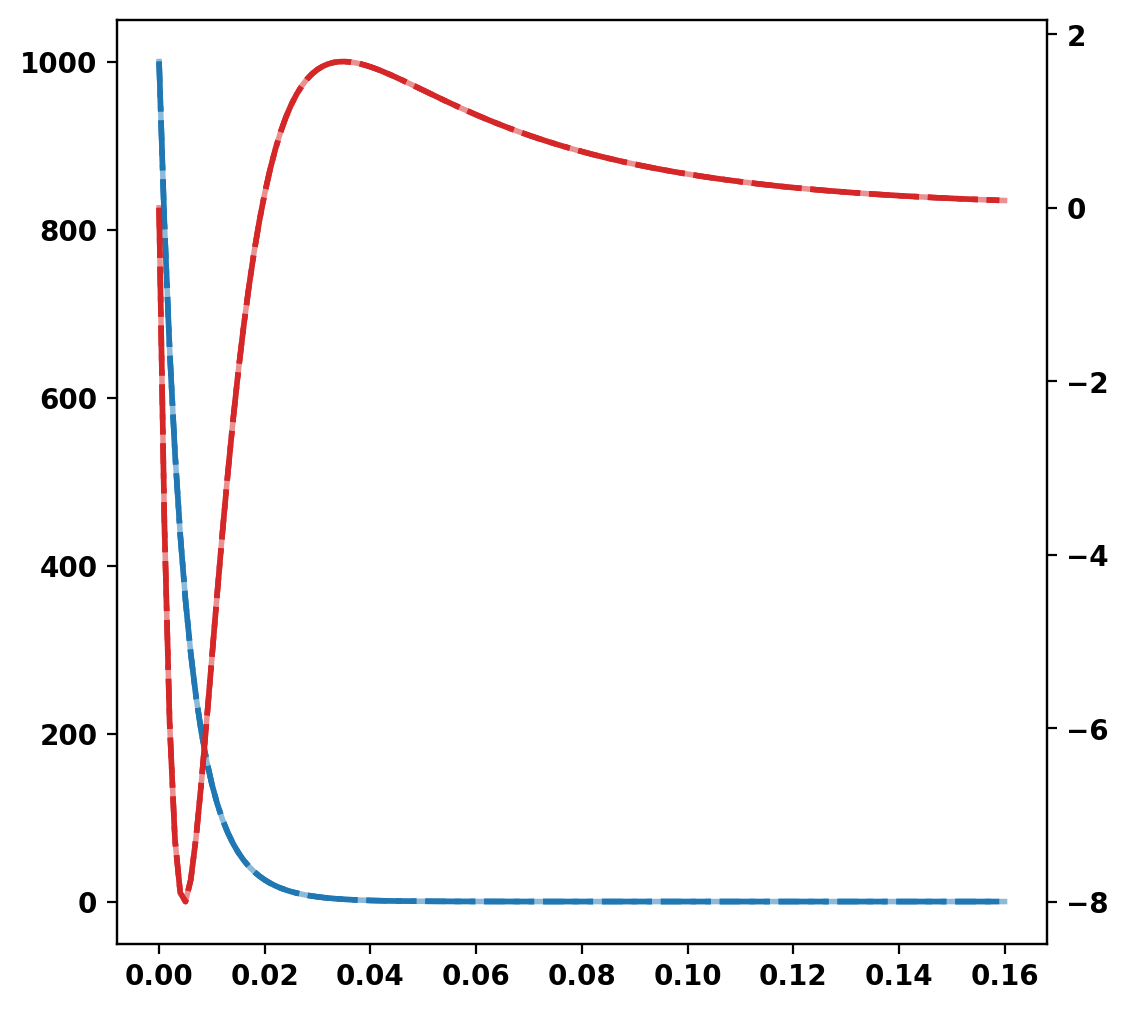

In [19]:
fig, ax = plt.subplots(1,1)
time = np.cumsum(dt*np.ones((len(coil_hist),)))-dt
ax.plot(time,coil_hist[:,0],color='tab:blue',alpha=0.5)
ax.plot(time[:-1],coil_hist_new[:,0],'--',color='tab:blue')
ax.plot(time[:-1],coil_hist_nl[:,0],'-.',color='tab:blue')
ax2=ax.twinx()
ax2.plot(time,coil_hist[:,1],color='tab:red',alpha=0.5)
ax2.plot(time[:-1],coil_hist_new[:,1],'--',color='tab:red')
_ = ax2.plot(time[:-1],coil_hist_nl[:,1],'-.',color='tab:red')